# LSTM


In [1]:
import json
import os
from datetime import datetime

import numpy as np
import pandas as pd
import torch
from scipy.interpolate import interp1d
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import RobustScaler
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
from tqdm.notebook import tqdm_notebook

import preprocessing
import process_outputs
import constants
import lstm

# Import data

In [2]:
train_timeseries_low_dim_2 = preprocessing.get_lower_dimension_2("train")
val_timeseries_low_dim_2 = preprocessing.get_lower_dimension_2("validation")
soil_data = preprocessing.load_clean_data("soil")

Loading existing clean soil data


# Data Preprocessing

We format the data in a 3D tensor, so that it can be processed by our LSTM model.

In [3]:
train_timeseries_low_dim_2 = train_timeseries_low_dim_2[train_timeseries_low_dim_2.fips.isin(train_timeseries_low_dim_2.fips.unique()[:10])]
val_timeseries_low_dim_2 = val_timeseries_low_dim_2[val_timeseries_low_dim_2.fips.isin(val_timeseries_low_dim_2.fips.unique()[:10])]


In [4]:
X_time_train, X_static_train, y_target_train = preprocessing.transform_data_3d(train_timeseries_low_dim_2, soil_data)
X_time_valid, X_static_valid, y_target_valid = preprocessing.transform_data_3d(val_timeseries_low_dim_2, soil_data)

X_time_train, X_static_train, scaler_dict, scaler_dict_static = preprocessing.normalize(X_static_train, X_time_train, fit=True)
X_time_valid, X_static_valid = preprocessing.normalize(X_static_valid, X_time_valid, scaler_dict, scaler_dict_static)

100%|██████████| 30/30 [00:00<00:00, 16953.53it/s]


In [5]:
# Data and task parameters
output_weeks = 6
batch_size = 128

train_data = TensorDataset(
    torch.tensor(X_time_train),
    torch.tensor(X_static_train),
    torch.tensor(y_target_train[:, :output_weeks]),
)
train_loader = DataLoader(
    train_data, shuffle=True, batch_size=batch_size, drop_last=False
)
valid_data = TensorDataset(
    torch.tensor(X_time_valid),
    torch.tensor(X_static_valid),
    torch.tensor(y_target_valid[:, :output_weeks]),
)
valid_loader = DataLoader(
    valid_data, shuffle=False, batch_size=batch_size, drop_last=False
)

# LSTM Parameters

In [8]:
# Model parameters
hidden_dim = 512
n_layers = 2
ffnn_layers = 2
dropout = 0.1
lr = 7e-5
epochs = 10
clip = 5

device = constants.DEVICE
print("Device: ", device)

Device:  cuda:0


# Define and train the model

In [9]:
static_dim = X_static_train.shape[-1]
model = lstm.DroughtNetLSTM(
    output_weeks,
    X_time_train.shape[-1],
    hidden_dim,
    n_layers,
    ffnn_layers,
    dropout,
    static_dim,
).to(device)

loss_function = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs
)

counter = 0
valid_loss_min = np.Inf
torch.manual_seed(42)
np.random.seed(42)
for i in tqdm(range(epochs)):
    h = model.init_hidden(batch_size)

    for k, (inputs, static, labels) in tqdm(
        enumerate(train_loader),
        desc=f"epoch {i+1}/{epochs}",
        total=len(train_loader),
    ):
        model.train()
        counter += 1
        if len(inputs) < batch_size:
            h = model.init_hidden(len(inputs))
        h = tuple([e.data for e in h])
        inputs, labels, static = (
            inputs.to(device),
            labels.to(device),
            static.to(device),
        )
        model.zero_grad()
        output, h = model(inputs, h, static)
        loss = loss_function(output, labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            if k == len(train_loader) - 1 or k == (len(train_loader) - 1) // 2:
                val_h = model.init_hidden(batch_size)
                val_losses = []
                model.eval()
                for inp, stat, lab in valid_loader:
                    if len(inp) < batch_size:
                        val_h = model.init_hidden(len(inp))
                    val_h = tuple([each.data for each in val_h])
                    inp, lab, stat = inp.to(device), lab.to(device), stat.to(device)
                    out, val_h = model(inp, val_h, stat)

                    val_loss = loss_function(out, lab.float())
                    val_losses.append(val_loss.item())

                    model.train()
                if np.mean(val_losses) <= valid_loss_min:
                    torch.save(model.state_dict(), "./state_dict.pt")
                    print(
                        "Epoch {} Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                            i, valid_loss_min, np.mean(val_losses)
                        )
                    )
                    valid_loss_min = np.mean(val_losses)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0 Validation loss decreased (inf --> 0.437198).  Saving model ...
Epoch 0 Validation loss decreased (0.437198 --> 0.436276).  Saving model ...


epoch 2/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 Validation loss decreased (0.436276 --> 0.432621).  Saving model ...
Epoch 1 Validation loss decreased (0.432621 --> 0.429749).  Saving model ...


epoch 3/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 Validation loss decreased (0.429749 --> 0.422521).  Saving model ...
Epoch 2 Validation loss decreased (0.422521 --> 0.418433).  Saving model ...


epoch 4/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 Validation loss decreased (0.418433 --> 0.410282).  Saving model ...
Epoch 3 Validation loss decreased (0.410282 --> 0.406490).  Saving model ...


epoch 5/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4 Validation loss decreased (0.406490 --> 0.399343).  Saving model ...
Epoch 4 Validation loss decreased (0.399343 --> 0.396162).  Saving model ...


epoch 6/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5 Validation loss decreased (0.396162 --> 0.390544).  Saving model ...
Epoch 5 Validation loss decreased (0.390544 --> 0.388100).  Saving model ...


epoch 7/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6 Validation loss decreased (0.388100 --> 0.384098).  Saving model ...
Epoch 6 Validation loss decreased (0.384098 --> 0.382493).  Saving model ...


epoch 8/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7 Validation loss decreased (0.382493 --> 0.380063).  Saving model ...
Epoch 7 Validation loss decreased (0.380063 --> 0.379255).  Saving model ...


epoch 9/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8 Validation loss decreased (0.379255 --> 0.378298).  Saving model ...
Epoch 8 Validation loss decreased (0.378298 --> 0.378071).  Saving model ...


epoch 10/10:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9 Validation loss decreased (0.378071 --> 0.377943).  Saving model ...
Epoch 9 Validation loss decreased (0.377943 --> 0.377943).  Saving model ...


# Output model's results

In [10]:
def predict(x, static=None):
    out, _ = model(torch.tensor(x).to(device), val_h, static.to(device))
    return out

In [11]:
dict_map = {
    "y_pred": [],
    "y_pred_rounded": [],
    "y_true": [],
    "week": [],
}
i = 0
for x, static, y in tqdm(
    valid_loader,
    desc="validation predictions...",
):
    val_h = tuple([each.data.to(device) for each in model.init_hidden(len(x))])
    with torch.no_grad():
        pred = predict(x, static).clone().detach()
    for w in range(output_weeks):
        dict_map["y_pred"] += [float(p[w]) for p in pred]
        dict_map["y_pred_rounded"] += [int(p.round()[w]) for p in pred]
        dict_map["y_true"] += [float(item[w]) for item in y]
        dict_map["week"] += [w] * len(x)
    i += len(x)
df = pd.DataFrame(dict_map)

validation predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/pierre_counathe/venvDLgcp/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [13]:
avg_f1 = 0
avg_mae = 0
for w in range(6):
    wdf = df[df['week']==w]
    mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    f1 = f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro').round(3)
    print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")
    avg_f1 += f1
    avg_mae += mae
avg_f1 /= 6
avg_mae /= 6
print(f"Mean mae : {avg_mae} // Mean F1: {avg_f1}")

Week 1 MAE 0.434 F1 0.282
Week 2 MAE 0.414 F1 0.289
Week 3 MAE 0.38 F1 0.296
Week 4 MAE 0.301 F1 0.296
Week 5 MAE 0.308 F1 0.289
Week 6 MAE 0.325 F1 0.267
Mean mae : 0.36033333333333334 // Mean F1: 0.2865


In [14]:
true = np.zeros((len(df[df['week']==0]['y_true']), 6))
pred = np.zeros((len(df[df['week']==0]['y_pred']), 6))

for i in tqdm_notebook(range(len(true))):
    true[i] = [df[df['week']==w]['y_true'].reset_index(drop = True).iloc[i] for w in range(6)]
    pred[i] = [df[df['week']==w]['y_pred'].reset_index(drop = True).iloc[i] for w in range(6)]

  0%|          | 0/30 [00:00<?, ?it/s]

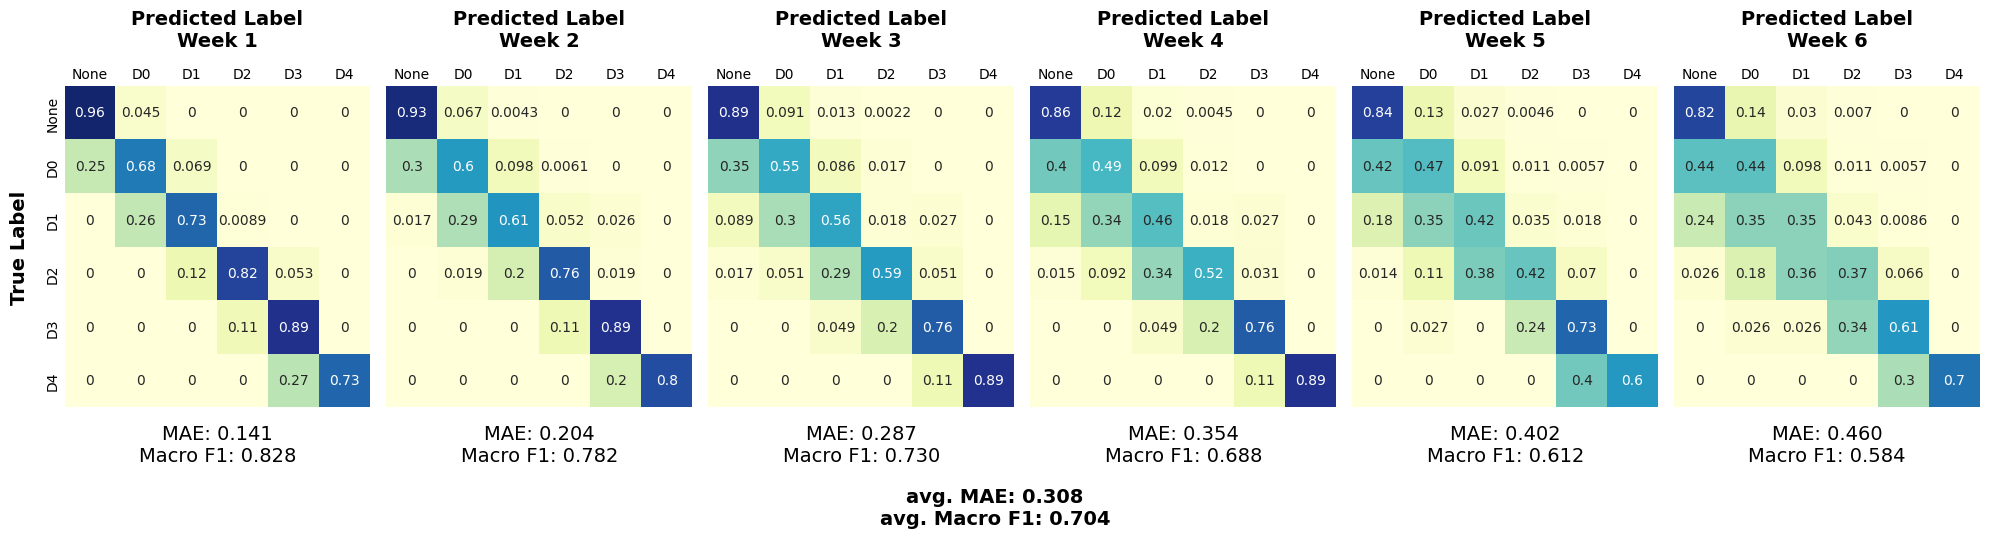

In [15]:
process_outputs.summarize(true, pred)